In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2)

n_samples = 100
var1 = np.random.normal(loc=3, scale=26, size=n_samples)
var2 = np.random.normal(loc=2, scale=28, size=n_samples)
# var3 = np.random.normal(loc=3, scale=47, size=n_samples)
# var4 = np.random.normal(loc=6, scale=7, size=n_samples)
var3 = np.random.normal(loc=8, scale=9, size=n_samples)
y = 8000*var1+6000*var2+np.random.normal(loc=0, scale=1, size=n_samples)
Y = []
for i in y:
    if i > 0:
        Y.append(1)
    else:
        Y.append(0)
#         print(1)
label = Y

In [2]:
data = pd.DataFrame({'var1': var1, 'var2': var2, 'var3': var3, 'Y': Y})
data

,var1,var2,var3,Y
0,-7.835704,34.522602,-2.359026,1
1,1.537062,12.810185,4.161298,1
2,-52.541098,-29.727732,6.666675,0
3,45.647041,14.126592,21.512932,1
4,-43.629325,-6.514420,15.826384,0
...,...,...,...,...
95,30.061423,52.525346,10.631889,1
96,12.892271,7.051475,-2.754999,1
97,-2.645517,17.488600,3.608625,1
98,33.511819,30.924814,6.442360,1


In [3]:
from scipy.stats import shapiro
# Test normal
for i in range(3):
    stat, p_value = shapiro(data.iloc[:, i])
    if p_value < 0.01:
        print(p_value,i)

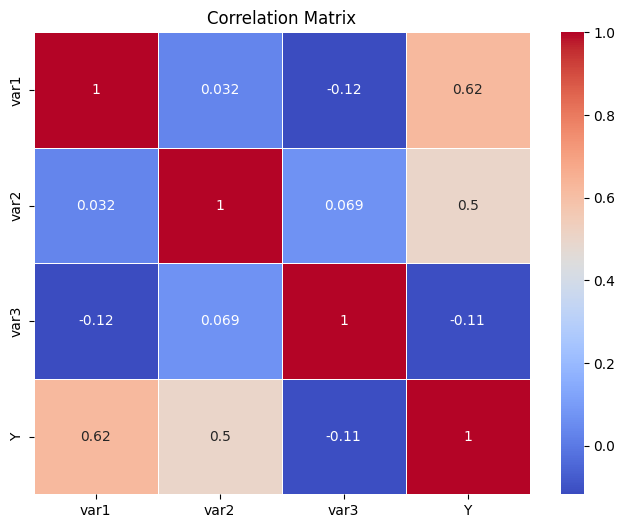

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 打印相关性系数
# print(correlation_matrix)

In [5]:
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]
X

,var1,var2,var3
0,-7.835704,34.522602,-2.359026
1,1.537062,12.810185,4.161298
2,-52.541098,-29.727732,6.666675
3,45.647041,14.126592,21.512932
4,-43.629325,-6.514420,15.826384
...,...,...,...
95,30.061423,52.525346,10.631889
96,12.892271,7.051475,-2.754999
97,-2.645517,17.488600,3.608625
98,33.511819,30.924814,6.442360


In [12]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.output(x)
        return torch.sigmoid(x)

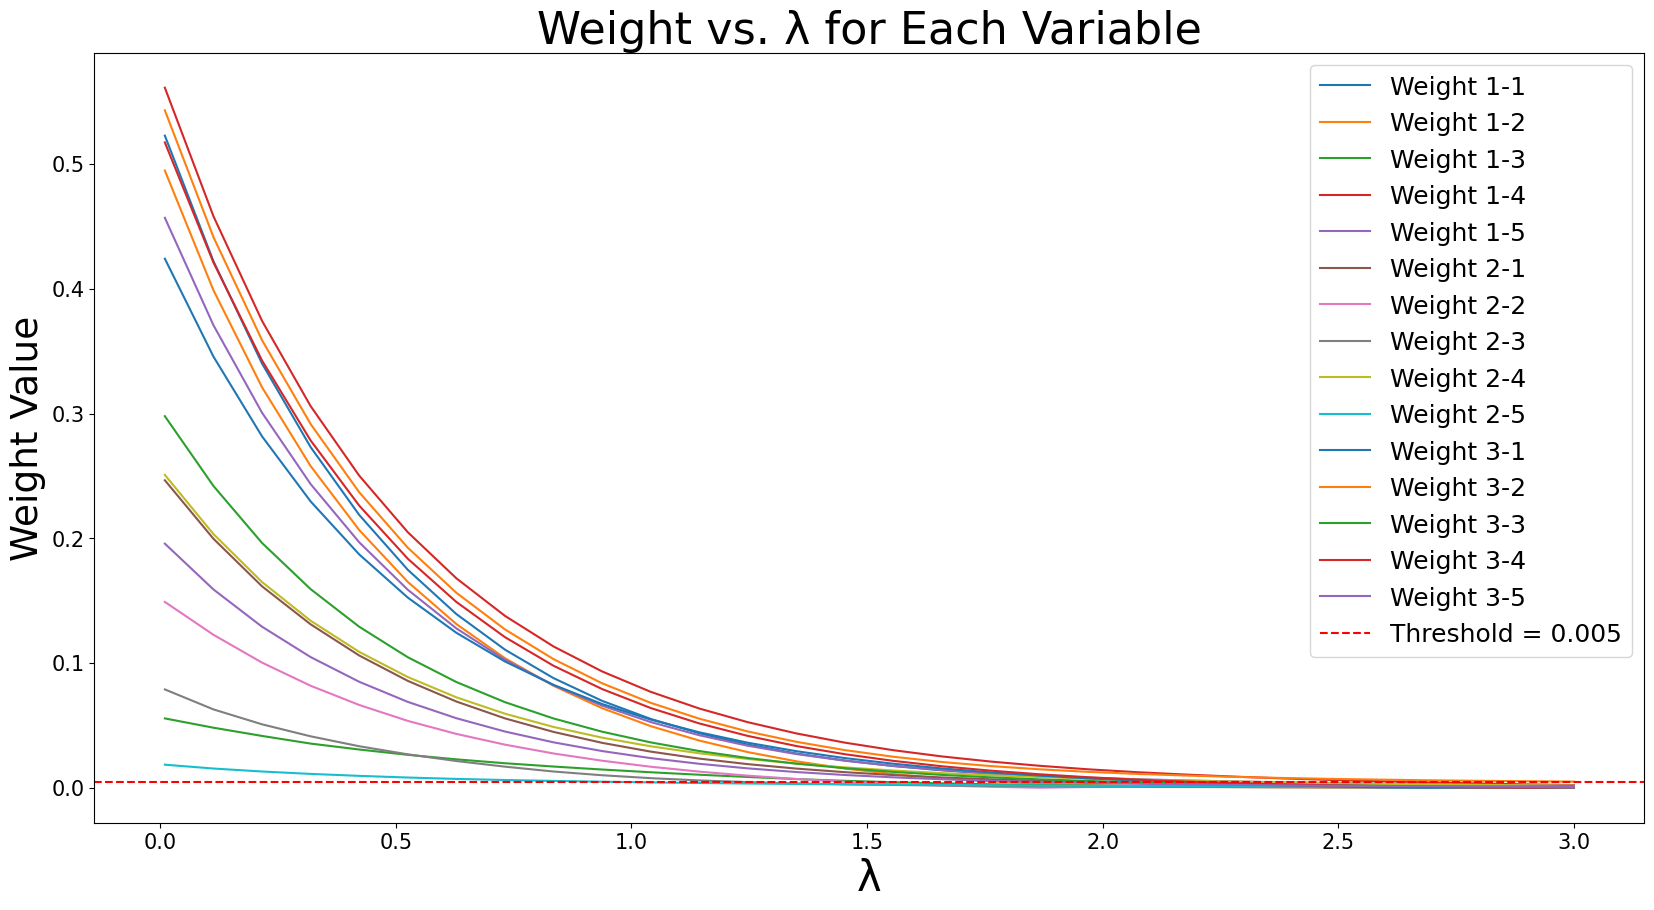

λ values when weights drop below threshold:
tensor([[2.2783, 1.9690, 2.1752],
        [1.8659, 1.4534, 3.0000],
        [1.5566, 1.2472, 2.0721],
        [2.6907, 2.2783, 2.1752],
        [2.3814, 0.9379, 1.8659]])

Intersection Points (λ, Weight):
λ values when weights drop below threshold:
tensor([[2.2783, 1.9690, 2.1752],
        [1.8659, 1.4534, 3.0000],
        [1.5566, 1.2472, 2.0721],
        [2.6907, 2.2783, 2.1752],
        [2.3814, 0.9379, 1.8659]])


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

net = Net(1,5,1)
net_copy = Net(1,5,1)
net_copy.load_state_dict(net.state_dict())

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

lambda_range = torch.linspace(3.0, 0.01, 30)

weights = []
lambda_array = torch.zeros_like(net.fc1.weight)

for lambda_val in lambda_range:
    net.load_state_dict(net_copy.state_dict())
    
    for epoch in range(100):
        optimizer.zero_grad()
        X_tensor = torch.FloatTensor(X.values)
        output = net(X_tensor)
        Y_tensor = torch.FloatTensor(Y.values)
        loss = criterion(output, Y_tensor)
        l2_reg = lambda_val * torch.sum(torch.pow(net.fc1.weight, 2))
        total_loss = loss + l2_reg
        total_loss.backward()
        optimizer.step()

    with torch.no_grad():
        below_threshold = (torch.abs(net.fc1.weight) < 0.005)
        lambda_array[below_threshold] = lambda_val.item()
        
    weight_values = [param.data.clone() for param in net.fc1.parameters() if len(param.size()) > 1][0]
    weight_values = weight_values.detach().cpu().numpy()
    weights.append(weight_values)

weights = np.array(weights)
intersection_points = [] 

plt.figure(figsize=(20, 10))
for j in range(weights.shape[2]):
    for i in range(weights.shape[1]):
        plt.plot(lambda_range.numpy(), abs(weights[:, i, j]), label=f'Weight {j + 1}-{i + 1}')

plt.axhline(y=0.005, color='r', linestyle='--', label='Threshold = 0.005')  # 添加阈值标签

plt.xlabel('\u03BB', fontsize=30)  # 调整x轴标题大小
plt.ylabel('Weight Value', fontsize=27)  # 调整y轴标题大小
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 18)
plt.title('Weight vs. \u03BB for Each Variable',fontsize=32)  
plt.savefig('your_plot.png', bbox_inches='tight')  # 修改文件名和格式
plt.show()

print("\u03BB values when weights drop below threshold:")
print(lambda_array)

print("\nIntersection Points (\u03BB, Weight):")
for point in intersection_points:
    print(f"({point[0]:.2f}, {point[1]:.3f})")


print("\u03BB values when weights drop below threshold:")
print(lambda_array)